In [2]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset
import copy

In [3]:
dataset = load_dataset('cifar100', split='test')

Found cached dataset cifar100 (/Users/andrejerkelens/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)


In [4]:
def show_img(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
cifar0 = dataset[0]['img']

In [7]:
cv_image = np.array(cifar0)

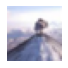

In [8]:
plt.figure(figsize=(1,1))
plt.imshow(cv_image)
plt.axis("off")
plt.show()

In [10]:
masks = mask_generator.generate(cv_image)

In [11]:
dataset[0]['coarse_label']

10

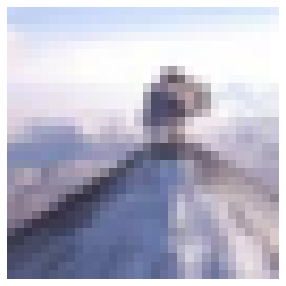

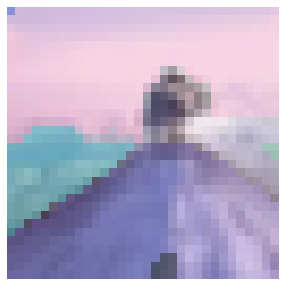

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(cv_image)
plt.axis('off')
plt.show();

plt.figure(figsize=(5,5))
plt.imshow(cv_image)
show_img(masks)
plt.axis('off')
plt.show();

In [13]:
import pickle

In [14]:
with open("output/interactions_cifar_test_0.pickle", "rb") as f:
    cifar0_interactions = pickle.load(f)

In [17]:
mask

NameError: name 'mask' is not defined

In [18]:
def find_edges(matrix):

    rows, cols = len(matrix), len(matrix[0])
    edges = []

    for i in range(rows):
        for j in range(cols):
            if matrix[i][j]:
                neighbors = []

                # Check neighboring cells
                if i - 1 >= 0:
                    neighbors.append(matrix[i - 1][j])
                if i + 1 < rows:
                    neighbors.append(matrix[i + 1][j])
                if j - 1 >= 0:
                    neighbors.append(matrix[i][j - 1])
                if j + 1 < cols:
                    neighbors.append(matrix[i][j + 1])

                # Check if there's at least one True and one False among the neighbors
                if True in neighbors and False in neighbors:
                    edges.append((i, j))

    return edges

In [19]:
cifar0_edges = []
for mask in masks:
    mask['edges'] = find_edges(mask['segmentation'])
    cifar0_edges.append(mask['edges'])

cifar0_edges = [e for m in cifar0_edges for e in m]

In [20]:
matching_keys = []

#TODO: Fix the keys in the drop code
for key in cifar0_interactions:
    for edge in cifar0_edges:
        if edge in key:
            matching_keys.append(key)

In [21]:
cifar0_avg_int = np.array(list(cifar0_interactions.values())).mean()

cifar0_edge_avg_int = np.array([cifar0_interactions[key] for key in matching_keys])

In [22]:
cifar0_avg_int

0.2379601

In [23]:
cifar0_edge_avg_int.mean()

0.18205738

In [24]:
matching_keys

[((0, 0), (15, 0)),
 ((0, 0), (16, 0)),
 ((0, 0), (26, 0)),
 ((0, 0), (27, 0)),
 ((0, 0), (15, 1)),
 ((0, 0), (16, 1)),
 ((0, 0), (25, 1)),
 ((0, 0), (26, 1)),
 ((0, 0), (14, 2)),
 ((0, 0), (15, 2)),
 ((0, 0), (24, 2)),
 ((0, 0), (26, 2)),
 ((0, 0), (13, 3)),
 ((0, 0), (14, 3)),
 ((0, 0), (24, 3)),
 ((0, 0), (25, 3)),
 ((0, 0), (13, 4)),
 ((0, 0), (14, 4)),
 ((0, 0), (23, 4)),
 ((0, 0), (25, 4)),
 ((0, 0), (13, 5)),
 ((0, 0), (14, 5)),
 ((0, 0), (22, 5)),
 ((0, 0), (24, 5)),
 ((0, 0), (13, 6)),
 ((0, 0), (14, 6)),
 ((0, 0), (22, 6)),
 ((0, 0), (23, 6)),
 ((0, 0), (13, 7)),
 ((0, 0), (14, 7)),
 ((0, 0), (21, 7)),
 ((0, 0), (22, 7)),
 ((0, 0), (13, 8)),
 ((0, 0), (15, 8)),
 ((0, 0), (21, 8)),
 ((0, 0), (22, 8)),
 ((0, 0), (14, 9)),
 ((0, 0), (16, 9)),
 ((0, 0), (20, 9)),
 ((0, 0), (21, 9)),
 ((0, 0), (14, 10)),
 ((0, 0), (16, 10)),
 ((0, 0), (19, 10)),
 ((0, 0), (21, 10)),
 ((0, 0), (14, 11)),
 ((0, 0), (16, 11)),
 ((0, 0), (19, 11)),
 ((0, 0), (20, 11)),
 ((0, 0), (13, 12)),
 ((0, 0), (

In [25]:
cifar0_interactions

{((0, 0), (1, 0)): 0.55671453,
 ((0, 0), (2, 0)): 0.5108725,
 ((0, 0), (3, 0)): 0.4357705,
 ((0, 0), (4, 0)): 0.4103806,
 ((0, 0), (5, 0)): 0.34632266,
 ((0, 0), (6, 0)): 0.45729977,
 ((0, 0), (7, 0)): 0.28916314,
 ((0, 0), (8, 0)): 0.46161404,
 ((0, 0), (9, 0)): 0.36525014,
 ((0, 0), (10, 0)): 0.38074702,
 ((0, 0), (11, 0)): 0.29846415,
 ((0, 0), (12, 0)): 0.27281907,
 ((0, 0), (13, 0)): 0.30728495,
 ((0, 0), (14, 0)): 0.21309558,
 ((0, 0), (15, 0)): 0.35498723,
 ((0, 0), (16, 0)): 0.30152938,
 ((0, 0), (17, 0)): 0.3692967,
 ((0, 0), (18, 0)): 0.21306477,
 ((0, 0), (19, 0)): 0.20300145,
 ((0, 0), (20, 0)): 0.20372272,
 ((0, 0), (21, 0)): 0.20699191,
 ((0, 0), (22, 0)): 0.1458333,
 ((0, 0), (23, 0)): 0.13754204,
 ((0, 0), (24, 0)): 0.1658686,
 ((0, 0), (25, 0)): 0.1290593,
 ((0, 0), (26, 0)): 0.129588,
 ((0, 0), (27, 0)): 0.14181541,
 ((0, 0), (28, 0)): 0.14072244,
 ((0, 0), (29, 0)): 0.5280399,
 ((0, 0), (30, 0)): 0.3026165,
 ((0, 0), (31, 0)): 0.44306445,
 ((0, 0), (0, 1)): 0.3422062

In [26]:
cifar0_edges

[(6, 18),
 (6, 19),
 (6, 20),
 (7, 17),
 (7, 21),
 (8, 17),
 (8, 22),
 (8, 23),
 (9, 16),
 (9, 24),
 (10, 15),
 (10, 24),
 (11, 15),
 (11, 24),
 (12, 15),
 (12, 24),
 (12, 25),
 (12, 26),
 (12, 27),
 (12, 28),
 (12, 29),
 (12, 30),
 (12, 31),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 8),
 (13, 12),
 (13, 15),
 (14, 2),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 13),
 (14, 14),
 (14, 15),
 (15, 0),
 (15, 1),
 (15, 15),
 (16, 16),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (16, 21),
 (17, 15),
 (17, 22),
 (17, 23),
 (18, 14),
 (18, 24),
 (18, 25),
 (19, 12),
 (19, 13),
 (19, 26),
 (20, 11),
 (20, 27),
 (21, 9),
 (21, 10),
 (21, 28),
 (21, 29),
 (22, 7),
 (22, 8),
 (22, 30),
 (23, 6),
 (23, 31),
 (24, 5),
 (25, 3),
 (25, 4),
 (26, 1),
 (26, 2),
 (27, 0),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (14, 7),
 (15, 2),
 (15, 8),
 (16, 0),
 (16, 1),
 (16, 9),
 (16, 10),
 (16, 11),
 (16, 12),
 (16, 13),
 (16, 14),
 (17, 13),
 (18, 12),
 (19, 10),
 (19, 11),
 (20, 9),
 (21, 7),
 (21, 8)

In [27]:
edges = find_edges(mask['segmentation'])

In [28]:
for mask in masks:
    print(mask)

{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 406, 'bbox': [0, 0, 31, 15], 'predicted_iou': 1.0037802457809448, 'point_coords': [[0.5, 14.5]], 'stability_score': 0.9685230255126953, 'crop_box': [0, 0, 32, 32], 'edges': [(6, 18), (6, 19), (6, 20), (7, 17), (7, 21), (8, 17), (8, 22), (8, 23), (9, 16), (9, 24), (10, 15), (10, 24), (11, 15), (11, 24), (12, 15), (12, 24), (12, 25), (12, 26), (12, 27), (12, 28), (12, 29), (12, 30), (12, 31), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (13, 12), (13, 15), (14, 2), (14, 9), (14, 10), (14, 11), (14, 13), (14, 14), (14, 15), (15, 0), (15, 1), (15, 15)]}
{'segmentation': array([[False, False, False, ..., False, Fa

In [29]:
cifar0_interactions[((0,0),(0,1))]

0.3422062

In [30]:
def get_neighbors(rows, cols, n_pixels):

    directions = [
        (-1, 0),  # up
        (1, 0),  # down
        (0, -1),  # left
        (0, 1),  # right
        (-1, -1),  # upper left diagonal
        (-1, 1),  # upper right diagonal
        (1, -1),  # lower left diagonal
        (1, 1)   # lower right diagonal
    ]

    result = {}

    for i in range(rows):
        for j in range(cols):
            neighbors = []
            for dx, dy in directions:
                for distance in range(1, n_pixels + 1):
                    x, y = i + dx * distance, j + dy * distance
                    if 0 <= x < rows and 0 <= y < cols:
                        neighbors.append((x, y))
            result[(i, j)] = neighbors

    return result

In [31]:
cv_image.shape[:-1]

(32, 32)

In [32]:
H,W = cv_image.shape[:-1]

In [33]:
all_neighbors = get_neighbors(H, W, 1)

In [34]:
surrounding_interactions = {}
surrounding_matrix = np.empty((32,32))
for i in range(H):
    for j in range(W):
        pix_val = (i,j)
        neigh = all_neighbors[pix_val]
        arr = []
        for n in neigh:
            pair = (pix_val, n)
            if pair in cifar0_interactions:
                arr.append(cifar0_interactions[pair])
            elif pair[::-1] in cifar0_interactions:
                arr.append(cifar0_interactions[pair[::-1]])
            else:
                raise ValueError("Pair not in interactions") 
        avg_int = np.mean(arr)
        surrounding_matrix[i,j] = avg_int
        surrounding_interactions[pix_val] = avg_int



In [35]:
import os

In [36]:
png_dir = 'plots/'

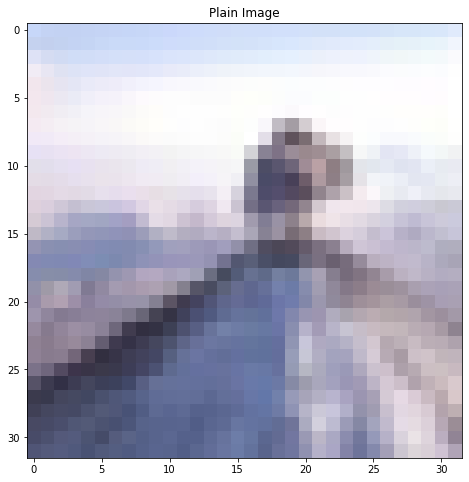

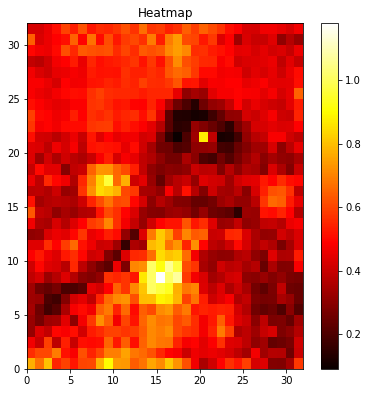

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(cv_image)
plt.title("Plain Image")
plt.savefig(os.path.join(png_dir,'cifar0_plain_img.png'), bbox_inches='tight', dpi=300)
plt.show();

plt.figure(figsize=(8,8))
plt.imshow(cv_image)
show_img(masks)
plt.title("Masked Image")
plt.savefig(os.path.join(png_dir,'cifar0_masked_img.png'), bbox_inches='tight', dpi=300)
plt.close();


plt.figure(figsize=(8,8))
heatmap = plt.pcolor(surrounding_matrix[::-1], cmap='hot')
plt.colorbar(heatmap)
plt.title("Heatmap")
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
plt.savefig(os.path.join(png_dir,'cifar0_imap_img.png'), bbox_inches='tight', dpi=300)
plt.show()

**General Trend Visualization:**
1. sample a target pixel on an object edge and measure interaction with a sample of **some pixels** on the same edge and pixels off that edge, but make them equal distances by either manhattan distance or euclidean from the target pixel
2. also sample target pixels that are internal to a particular object, and measure interactions with a sample of pixels that are either in the same object or outside the boundary
3. plot, with x axis as euclidean distance, the different trendlines for pixels that share the same edge and pixels that either fall inside that object or outside the object that it marks the edge of (3 different trendlines)
4. plot 2 different trend lines for pixels that are in the same object and pixels that are off of that object

In [57]:
mask

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 8,
 'bbox': [17, 29, 2, 2],
 'predicted_iou': 0.9089388251304626,
 'point_coords': [[19.5, 29.5]],
 'stability_score': 1.0,
 'crop_box': [0, 0, 32, 32],
 'edges': [(29, 18), (29, 19), (30, 17), (30, 19), (31, 17), (31, 19)]}

In [58]:
mask['edges']

[(29, 18), (29, 19), (30, 17), (30, 19), (31, 17), (31, 19)]

In [59]:
from itertools import combinations

In [86]:
from collections import defaultdict

def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])


def get_pixels_at_distance(N,M,ref_point,all_edges, dist):
    result = []
    
    for i in range(N):
        for j in range(M):
            if manhattan_distance(ref_point, (i, j)) == dist and (i,j) not in all_edges:
                result.append((i, j))
    
    return result


all_interactions = {}

for mask in masks:
    m_edges = mask['edges']
    all_combs = list(combinations(m_edges, 2))

    for p0, p1 in all_combs:
        m_dist = manhattan_distance(p0, p1)
        p_pair = ((p0),(p1))
        if p_pair in cifar0_interactions:
            edge_interaction = cifar0_interactions[p_pair]
        else:
            edge_interaction = cifar0_interactions[p_pair[::-1]]

        if m_dist not in all_interactions:
            all_interactions[m_dist] = {}
            all_interactions[m_dist]["edge"] = []
            all_interactions[m_dist]["non_edge"] = []
        all_interactions[m_dist]["edge"].append(edge_interaction)

        if len(cv_image.shape) == 3:
            n,m = cv_image.shape[:-1]
        elif len(cv_image.shape) == 2:
            n,m = cv_image.shape

        outside_edge_interaction = get_pixels_at_distance(n,m, p0, m_edges, m_dist)

        for non_edge in outside_edge_interaction:
            p_pair = ((p0),(non_edge))

            if p_pair in cifar0_interactions:
                ne_interaction = cifar0_interactions[p_pair]
            else:
                ne_interaction = cifar0_interactions[p_pair[::-1]]
            
            all_interactions[m_dist]["non_edge"].append(ne_interaction)


In [88]:
for distances in all_interactions:
        
        print(f"Manhattan Distance: {distances}")
        print(f"Average Interaction on Edges: {np.mean(all_interactions[distances][edge])}")

dict_keys([1, 2, 4, 3, 6, 7, 5, 9, 10, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 21, 20, 24, 27, 26, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35])